<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/ADMIR_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [1]:
!pip install --upgrade nibabel

     |████████████████████████████████| 3.3MB 12.2MB/s 
  Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
import os, sys, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

print("nibabel version: {}".format(nb.__version__))
print("pytorch version: {}".format(torch.__version__))

nibabel version: 3.2.0
pytorch version: 1.7.0+cu101


In [4]:
t1_fn = '/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/ADMIR/Dataset/IXI002-Guys-0828-T1_resampled.nii.gz'
t2_fn = '/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/ADMIR/Dataset/IXI002-Guys-0828-T2_resampled.nii.gz'  

In [5]:
data_path = "/content/drive/My Drive/Colab Notebooks/image_registration/resampled_mri/admir_data/"
file_names = glob.glob(os.path.join(data_path, "*.nii.gz"))

In [6]:
len(file_names)

5

In [7]:
!ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Nov 13 17:33 sample_data
drwx------ 5 root root 4096 Nov 17 14:42 drive


# Image Processing

In [8]:
img_nb1 = nb.load(file_names[0])
img_nb1.shape
img_nb2 = nb.load(file_names[1])
img_nb2.shape

(128, 128, 128)

In [9]:
def load_4D(name):
    X_nb = nb.load(name)
    X_np = X_nb.dataobj
    X_np = np.reshape(X_np, (1,)+ X_np.shape)
    return X_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

In [10]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, names,iterations,norm=True):
        'Initialization'
        self.names = names
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.names) * 2

  def __getitem__(self, step):
        'Generates one sample of data'
        # Select sample
        # print(self.names)
        index_pair = np.random.permutation(len(self.names)) [0:4]
        img_A = load_4D(self.names[index_pair[0]])
        img_B = load_4D(self.names[index_pair[1]])     
        
        if self.norm:
            return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
        else:
            return img_A, img_B



In [11]:
training_generator = Data.DataLoader(Dataset(file_names,iterations=2,norm=True), batch_size=2, shuffle=True)

In [12]:
ex1 = torch.rand(2, 40, 4, 4, 4)
ex2 = ex1.flatten(start_dim=1, end_dim=4)
ex2.shape

torch.Size([2, 2560])

In [13]:
for X,Y in training_generator:
  print(X.shape)
  print(Y.shape)

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])


# Building Affine Model

In [17]:
class Admir_Affine_Encoder(nn.Module):
    def __init__(self, in_channel, start_channel, num_conv_blocks=6):
        self.in_channel = in_channel
        self.start_channel = start_channel
        self.num_conv_blocks = num_conv_blocks
        self.encoder_layer_list = []
        super(Admir_Affine_Encoder, self).__init__()
        self.create_model()

    def affine_conv_block(self, in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias=True ):
      layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                            nn.BatchNorm3d(out_channels),
                            nn.LeakyReLU(negative_slope=0.1))
      return layer
    

    def create_model(self):
      for i in range(self.num_conv_blocks):
          if(i == 0):
            lyr = self.affine_conv_block(in_channels = self.in_channel, out_channels = self.start_channel)
            self.encoder_layer_list.append(lyr)
          else:
            lyr = self.affine_conv_block(in_channels= self.start_channel * i, out_channels = self.start_channel * (i+1))
            self.encoder_layer_list.append(lyr)

    def forward(self, x, y):
      # print("x,y", x.shape, "  ", y.shape)
      x_in=torch.cat((x, y), 1)
      e0 = self.encoder_layer_list[0](x_in)
      e1 = self.encoder_layer_list[1](e0)
      e2 = self.encoder_layer_list[2](e1)
      e3 = self.encoder_layer_list[3](e2)
      e4 = self.encoder_layer_list[4](e3)
      return e4


In [13]:
affine_conv_model = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)

In [16]:
class Admir_Affine_Output(nn.Module):
  def __init__(self, in_units, out_units=128, dropout_prob = 0.3):
    
    self.in_units = in_units
    self.out_units = out_units
    self.dropout_prob = dropout_prob
    super(Admir_Affine_Output, self).__init__()
    self.trns_ob = self.translation_output_block(self.in_units, self.out_units)
    self.rss_ob = self.rot_scale_shear_output_block(self.in_units, self.out_units)
    return;
  
  def translation_output_block(self, in_units, out_units):
    layer = nn.Sequential(
          nn.Linear(in_features = in_units, out_features= out_units),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units, out_features= out_units//2),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units//2, out_features= out_units//4),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units//4, out_features= out_units//8),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units//8, out_features= 3))
    return layer

  def rot_scale_shear_output_block(self, in_units, out_units):
    layer = nn.Sequential(
          nn.Linear(in_features = in_units, out_features= out_units),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units, out_features= out_units//2),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units//2, out_features= out_units//4),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units//4, out_features= out_units//8),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features=out_units//8, out_features= 9),
          nn.Tanh())
    return layer
  
  def forward(self, input_tnsr):
    ip = input_tnsr.flatten(start_dim=1, end_dim=4)
    #print(ip.shape)
    translation_output = self.trns_ob(ip)
    rotate_scale_shear_output = self.rss_ob(ip)
    return [translation_output, rotate_scale_shear_output]

In [15]:
affine_output_model = Admir_Affine_Output( in_units= 2560)

In [52]:
for X,Y in training_generator:
  print(X.shape)
  print(Y.shape)
  conv_out = affine_conv_model(X, Y)
  print(conv_out.shape)
  output_out = affine_output_model(conv_out)
  print(output_out[0].shape)
  print(output_out[1].shape)
  print("========== ============== =============")
  print()

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============



# Spatial Transform

In [38]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (2, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)        
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


In [39]:
spatial_transformer_affine = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=torch.randn(size=(2, 3, 4)))
print(spatial_transformer_affine.grid.shape)
print(spatial_transformer_affine.isaffine)
print("========= =========== ======")
print()

torch.Size([2, 128, 128, 128, 3])
True
========= =========== ======



In [40]:
spatial_transformer_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False)
print(spatial_transformer_deformable.grid.shape)
print(spatial_transformer_deformable.isaffine)
print("========= =========== ======")
print()

torch.Size([1, 3, 128, 128, 128])
False
========= =========== ======



# Deformable ConvNet

In [19]:
class Admir_Deformable_UNet(nn.Module):
  def __init__(self,in_channel  , n_classes,start_channel):
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.start_channel = start_channel
        super(Admir_Deformable_UNet, self).__init__()
        self.eninput = self.encoder(self.in_channel, self.start_channel, bias=False)

        self.ec1 = self.encoder(self.start_channel, self.start_channel, bias=False)
        self.ec2 = self.encoder(self.start_channel, self.start_channel*2, stride=2, bias=False)

        self.ec3 = self.encoder(self.start_channel*2, self.start_channel*2, bias=False)
        self.ec4 = self.encoder(self.start_channel*2, self.start_channel*4, stride=2, bias=False)

        self.ec5 = self.encoder(self.start_channel*4, self.start_channel*4, bias=False)
        self.ec6 = self.encoder(self.start_channel*4, self.start_channel*8, stride=2, bias=False)

       
    
        self.dc1 = self.encoder(self.start_channel*8, self.start_channel*8, kernel_size=3, stride=1, bias=False) 
        self.dc2 = self.encoder(self.start_channel*4, self.start_channel*4, kernel_size=3, stride=1, bias=False)          
        self.dc3 = self.encoder(self.start_channel*2, self.start_channel*2, kernel_size=3, stride=1, bias=False)

        self.up1 = self.decoder(self.start_channel*8, self.start_channel*4)
        self.up2 = self.decoder(self.start_channel*4, self.start_channel*2)
        self.up3 = self.decoder(self.start_channel*2, self.start_channel)

        self.dc4 = self.output(self.start_channel, self.n_classes,kernel_size=1,bias=False)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                bias=True):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.LeakyReLU(negative_slope=0.1))
    return layer

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
            nn.LeakyReLU(negative_slope=0.1))
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, 
                bias=False, batchnorm=False):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias),
               )
    return layer

  def forward(self, x,y):
        # print("x,y", x.shape, "  ", y.shape)
        x_in=torch.cat((x, y), 1)  
        e0 = self.eninput(x_in)

        # print("e0", e0.shape)

        e0 = self.ec1(e0)
        es1 = self.ec2(e0)   #strided
        # print("e0", e0.shape)
        # print("es1", es1.shape)

        e1 = self.ec3(es1)   
        es2 = self.ec4(e1)   #strided
        # print("e1", e1.shape)
        # print("es2", es2.shape)

        e2 = self.ec5(es2)
        es3 = self.ec6(e2)   #strided
        # print("e2", e2.shape)
        # print("es3", es3.shape)

        

        d0 = self.dc1(es3)
        # print("d0", d0.shape)

        d0 = torch.add(self.up1(d0), e2)
        # print("d0", d0.shape)

        d1 = self.dc2(d0)
        d1 = torch.add(self.up2(d1), e1)
        # print("d1", d1.shape)

        d2 = self.dc3(d1)
        d2 = torch.add(self.up3(d2), e0)
        print("d2", d2.shape)

        output = self.dc4(d2)
        return output

In [20]:
torch.cuda.empty_cache()
model = Admir_Deformable_UNet(2,3,16).cuda() # assining cuda to model

for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  print(X.shape)
  print(Y.shape)
  out = model(X, Y)
  print(out.shape)
  print("========== ============== =============")
  print()

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
d2 torch.Size([2, 16, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
d2 torch.Size([2, 16, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
d2 torch.Size([2, 16, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
d2 torch.Size([2, 16, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
d2 torch.Size([2, 16, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============



# Aggregation Affine DVF and Deformable DVF 


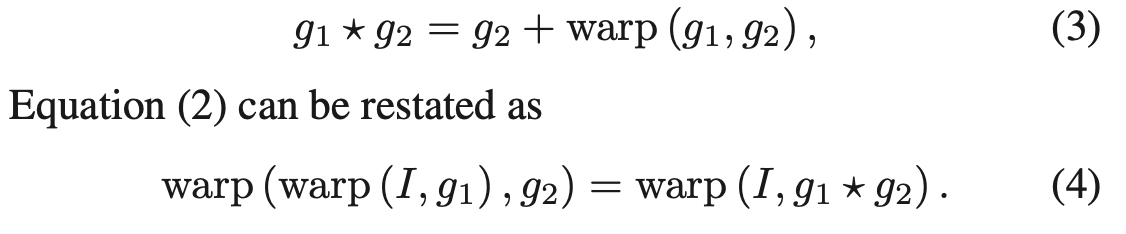





**Steps:**
 According to eq. 3, warp DVF of affine(g1) with DVF of deformable(g2), and then add the result to DVF of deformable(g2).


In [41]:
affine_conv_model = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)
affine_output_model = Admir_Affine_Output( in_units= 2560)
stn_affine = SpatialTransformer(size=(128, 28, 128), is_affine=True, theta=torch.randn(size=(2, 3, 4)))

deformable_model = Admir_Deformable_UNet(2,3,16)

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_aggregation = SpatialTransformer(size=(128, 128, 128), is_affine=False)

stn_fully_warped = SpatialTransformer(size=(128, 128, 128), is_affine=False)



In [42]:
stn_affine.grid.shape

torch.Size([2, 128, 128, 128, 3])

In [43]:
final_warped_image = stn_deformable(torch.randn(size=(2,3,128,128,128)), torch.randn(size=(2,3,128,128,128)) )

In [44]:
final_warped_image.shape

torch.Size([2, 3, 128, 128, 128])

In [47]:
batch_size = 2


# X --> fixed and Y --> moving

for X,Y in training_generator:

  # X = X.cuda().float()
  # Y = Y.cuda().float()

  print("X shape: {}".format(X.shape))
  print("Y shape: {}".format(Y.shape))
  affine_conv_out = affine_conv_model(X, Y)
  # print(affine_conv_out.shape)

  affine_output_out = affine_output_model(affine_conv_out)
  print(affine_output_out[0].shape)
  print(affine_output_out[1].shape)

  print("========== ============== =============")
  print()

  affine_tnsr = torch.cat((affine_output_out[1], affine_output_out[0]), 1)
  theta = torch.reshape(affine_tnsr, (batch_size, 3, 4))

  
  # Suraj: Set the new theta and reshape it
  stn_affine.theta = theta
  print("========== ============== =============")
  print("theta shape: {}".format(theta.shape))
  print(theta)

  # print("========== ============== =============")
  # grid = F.affine_grid(theta, (2, 1, 128, 128, 128))
  # print(grid.shape)
  # print(grid)

  # Suraj: Added coarsely warped image, changed dvf_final calculation
  # DVF1 shape was [batch size, 128, 128, 128, 3] --> permuted order of columns to match deformable dvf 2 [batch size, 3, 128, 128, 128]
  coarsely_warped_image = stn_affine(Y)
  dvf_1 = stn_affine.grid
  dvf_1 = dvf_1.permute(0, 4, 1, 2, 3)

  print("======= =============== ===========")
  print("Coarsely warped image shape: {}".format(coarsely_warped_image.shape))
  print("dvf 1 shape: {}".format(dvf_1.shape))
  print("=========== ============= ==========")
  print()

  print(" ==== Starting deformable warping =======")
  dvf_2 = deformable_model(coarsely_warped_image, Y) 
  print("deformable field dvf 2 shape: {}".format(dvf_2.shape))
  print("========== ============== =============")
  print()

  print(" interim warp ")
  interim_warp_field = stn_aggregation(dvf_1,dvf_2)
  print("interim warp field shape: {}".format(interim_warp_field.shape))
  print("========== ============== =============")
  print()

  
  dvf_final = dvf_2 + interim_warp_field
  print("final dvf shape: {}".format(dvf_final.shape))
  print("========== ============== =============")
  print()

  fully_warped_image =  stn_fully_warped(Y,dvf_final)  #final fully warped image , i.e. equation 4 of the image
  print("final warped image shape: {}".format(fully_warped_image.shape))
  print("========== ============== =============")
  print()
  

  del X
  del Y
  del interim_warp_field
  del dvf_1
  del dvf_2
  del dvf_final
  del fully_warped_image

  """
  # something is missing here may be: TBD

  dvf_1 = F.grid_sample(Y, grid)    #named as g1 in the image
  print(dvf_1.shape)
  print("========== ============== =============")
  print()
  
  dvf_2 = deformable_model(dvf_1, Y)     #named as g2 in the image
  print(dvf_2.shape)
  print("========== ============== =============")
  print()
  
  dvf_final = dvf_2 + stn_aggregation(dvf_1,dvf_2)    # g1 * g2,  aggregation of DVF (Affine) and DVF (Deformable)
  print(dvf_final.shape)
  print("========== ============== =============")
  print()

  fully_warped_image =  stn_fully_warped(Y,dvf_final)  #final fully warped image , i.e. equation 4 of the image
  print(fully_warped_image.shape)
  print("========== ============== =============")
  print()
  """
  

X shape: torch.Size([2, 1, 128, 128, 128])
Y shape: torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

========== ============== =============
theta shape: torch.Size([2, 3, 4])
tensor([[[-0.1161, -0.2802, -0.3322, -0.1159],
         [-0.1681, -0.4785,  0.0086, -0.1808],
         [-0.1069,  0.1317, -0.0420,  0.2455]],

        [[ 0.0276, -0.2756, -0.2953,  0.0351],
         [-0.0728, -0.1741, -0.1754, -0.0482],
         [-0.2195,  0.2257,  0.0267,  0.4620]]], grad_fn=<ViewBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


======= =============== ===========
Coarsely warped image shape: torch.Size([2, 1, 128, 128, 128])
dvf 1 shape: torch.Size([2, 3, 128, 128, 128])
=========== ============= ==========

 ==== Starting deformable warping =======
d2 torch.Size([2, 16, 128, 128, 128])
deformable field dvf 2 shape: torch.Size([2, 3, 128, 128, 128])
========== ============== =============

 interim warp 
interim warp field shape: torch.Size([2, 3, 128, 128, 128])
========== ============== =============

final dvf shape: torch.Size([2, 3, 128, 128, 128])
========== ============== =============

final warped image shape: torch.Size([2, 1, 128, 128, 128])
========== ============== =============

X shape: torch.Size([2, 1, 128, 128, 128])
Y shape: torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

========== ============== =============
theta shape: torch.Size([2, 3, 4])
tensor([[[-0.1642, -0.2519, -0.2274, -0.0296],
         [-0.0043, -0.4660,  0.0361

# Loss Function NCC

Reference: https://github.com/yuta-hi/pytorch_similarity

In [ ]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc

    return ncc, ncc_map


In [ ]:


class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [ ]:
#  Checking NCC loss

similarity_loss = NormalizedCrossCorrelation()
for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  print(X.shape)
  print(Y.shape)
  out = similarity_loss(X, Y)
  print(out)
  print("========== ============== =============")
  print()

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.7159, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.7159, device='cuda:0')
========== ============== =============



# Regularizer - DVF edge smoothness

In [ ]:
def smoothness_regularizer(input_tensor=None):
  if(input_tensor == None):
    dvf_tensor = torch.randn(size=(4, 3, 128, 128, 128))
  else:
    dvf_tensor = input_tensor
  
  dvf_x = dvf_tensor[:, 0:1, ...]
  dvf_y = dvf_tensor[:, 1:2, ...]
  dvf_z = dvf_tensor[:, 2:3, ...]

  sobel_z = torch.FloatTensor( [ [ [ [ [1,2,1], [2,4,2], [1,2,1] ], [ [0,0,0], [0,0,0], [0,0,0] ], [ [-1,-2,-1], [-2,-4,-2], [-1,-2,-1] ] ] ] ] )
  sobel_y = torch.FloatTensor( [ [ [ [ [1,2,1], [0,0,0], [-1,-2,-1] ], [ [2,4,2], [0,0,0], [-2,-4,-2] ], [ [1,2,1], [0,0,0], [-1,-2,-1] ] ] ] ] )
  sobel_x = torch.FloatTensor( [ [ [ [ [1,0,-1], [2,0,-2], [1,0,-1] ], [ [2,0,-2], [4,0,-4], [2,0,-2] ], [ [1,0,-1], [2,0,-2], [1,0,-1] ] ] ] ] )

  edges_x = F.conv3d(input=dvf_x, weight=sobel_x , stride=1, padding=1)
  edges_y = F.conv3d(input=dvf_y, weight=sobel_y , stride=1, padding=1)
  edges_z = F.conv3d(input=dvf_z, weight=sobel_z , stride=1, padding=1)

  magnitude_of_edges_along_x = torch.norm(edges_x)
  magnitude_of_edges_along_y = torch.norm(edges_y)
  magnitude_of_edges_along_z = torch.norm(edges_z)
  print("Magnitudes of gradients along x, y and z are {}, {} and {}".format(magnitude_of_edges_along_x, magnitude_of_edges_along_y, magnitude_of_edges_along_z))

  return magnitude_of_edges_along_x + magnitude_of_edges_along_y + magnitude_of_edges_along_z

print(smoothness_regularizer())


Magnitudes of gradients along x, y and z are 24255.912109375, 24283.439453125 and 24284.369140625
tensor(72823.7188)


In [ ]:
dvf_tensor = torch.randn(size=(4, 3, 128, 128, 128))

dvf_x = dvf_tensor[:, 0:1, ...]
dvf_y = dvf_tensor[:, 1:2, ...]
dvf_z = dvf_tensor[:, 2:3, ...]
print(dvf_z.shape)

torch.Size([4, 1, 128, 128, 128])


In [ ]:
sobel_z = torch.FloatTensor( [ [ [ [ [1,2,1], [2,4,2], [1,2,1] ], [ [0,0,0], [0,0,0], [0,0,0] ], [ [-1,-2,-1], [-2,-4,-2], [-1,-2,-1] ] ] ] ] )
sobel_y = torch.FloatTensor( [ [ [ [ [1,2,1], [0,0,0], [-1,-2,-1] ], [ [2,4,2], [0,0,0], [-2,-4,-2] ], [ [1,2,1], [0,0,0], [-1,-2,-1] ] ] ] ] )
sobel_x = torch.FloatTensor( [ [ [ [ [1,0,-1], [2,0,-2], [1,0,-1] ], [ [2,0,-2], [4,0,-4], [2,0,-2] ], [ [1,0,-1], [2,0,-2], [1,0,-1] ] ] ] ] )
print(sobel_x.shape)

torch.Size([1, 1, 3, 3, 3])


In [ ]:
edges_x = F.conv3d(input=dvf_x, weight=sobel_x , stride=1, padding=1)
edges_y = F.conv3d(input=dvf_y, weight=sobel_y , stride=1, padding=1)
edges_z = F.conv3d(input=dvf_z, weight=sobel_z , stride=1, padding=1)

In [ ]:
edges_y.shape

torch.Size([4, 1, 128, 128, 128])

In [ ]:
magnitude_of_edges_along_x = torch.norm(edges_x)
magnitude_of_edges_along_y = torch.norm(edges_y)
magnitude_of_edges_along_z = torch.norm(edges_z)
print("Magnitudes of gradients along x, y and z are {}, {} and {}".format(magnitude_of_edges_along_x, magnitude_of_edges_along_y, magnitude_of_edges_along_z))

Magnitudes of gradients along x, y and z are 24247.083984375, 24260.341796875 and 24270.322265625


In [ ]:
sobel_np_z

array([[[ 1.,  2.,  1.],
        [ 2.,  4.,  2.],
        [ 1.,  2.,  1.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[-1., -2., -1.],
        [-2., -4., -2.],
        [-1., -2., -1.]]], dtype=float32)

In [ ]:
sobel_np_y

array([[[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]],

       [[ 2.,  4.,  2.],
        [ 0.,  0.,  0.],
        [-2., -4., -2.]],

       [[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]]], dtype=float32)

In [ ]:
sobel_np_x

array([[[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]],

       [[ 2.,  0., -2.],
        [ 4.,  0., -4.],
        [ 2.,  0., -2.]],

       [[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]]], dtype=float32)